In [1]:
import sys
sys.path.append("/home/bgreene/SBL_LES/python/")
import yaml
import numpy as np
import xarray as xr
import seaborn
from cmocean import cm
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESnc import load_stats
from RFMnc import recalc_err

In [2]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
props=dict(boxstyle="square",facecolor="white",edgecolor="white",alpha=0.0)
props2=dict(boxstyle='square',facecolor='white',alpha=0.85)

# Load Data

In [3]:
# load yaml file
with open("/home/bgreene/SBL_LES/python/RFMnc.yaml") as f:
    config = yaml.safe_load(f)
# directories
# figure save
figdir = "/home/bgreene/SBL_LES/figures/RFMnc/"
# list of simulations to loop over
# sims = ["cr0.10_u08", "cr0.25_u08", "cr0.33_u08", "cr0.50_u08",
#         "cr1.00_u08", "cr1.50_u08"]#, "cr2.00_u08", "cr2.50_u08"]
sims = ["cr0.25_u08", "cr0.50_u08", "cr1.00_u08", 
        "cr1.50_u08", "cr2.00_u08", "cr2.50_u08"]
# dictionary of conversions from old label convention (A-F)
labels = {"cr0.25_u08_192": "A",
          "cr0.50_u08_192": "B",
          "cr1.00_u08_192": "C",
          "cr1.50_u08_192": "D",
          "cr2.00_u08_192": "E",
          "cr2.50_u08_192": "F"}
# empty list to construct paths and store
dnc_all = []
sall = []
Lall = []
Aall = []
err = []
Call, pall = [], []
# loop over sims and load stats, spectrogram data
for sim in sims:
    dnc = f"/home/bgreene/simulations/{sim}_192/output/netcdf/"
    dnc_all.append(dnc)
    # load stats file
    s = load_stats(dnc+"average_statistics.nc")
    # add labels from convention for JAS paper (A-F)
    if s.stability in labels.keys():
        s.attrs["label2"] = labels[s.stability]
    else:
        s.attrs["label2"] = s.label
    sall.append(s)
    # load integral lengthscales
    l = xr.load_dataset(dnc+"L.nc")
    Lall.append(l)
    # load autocorr files
    a = xr.load_dataset(dnc+"autocorr.nc")
    Aall.append(a)
    # load error files
    e = xr.load_dataset(dnc+"err.nc")
    err.append(e)
    # load RFM coefficients
    Call.append(xr.load_dataset(dnc+"fit_C.nc"))
    pall.append(xr.load_dataset(dnc+"fit_p.nc"))
    
# define colormap based on number of simulations
nsim = len(sims)
cmap = seaborn.color_palette("cubehelix_r", nsim)
colors = seaborn.color_palette("crest", nsim)

Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr1.00_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr1.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.00_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.50_u08_192/output/netcdf/average_statistics.nc


# Plot Integral Lengthscales

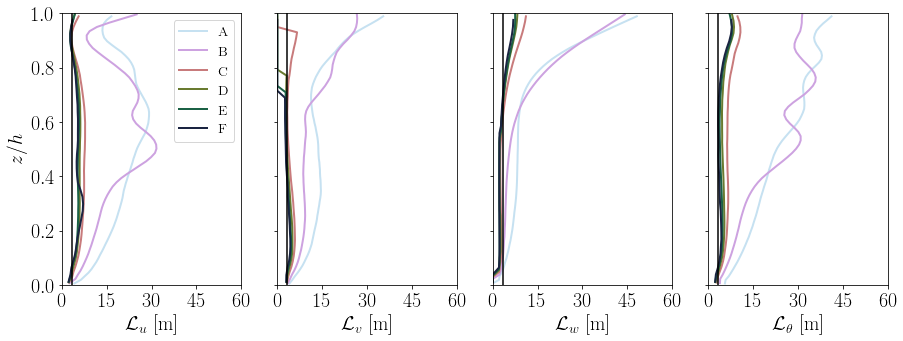

In [4]:
# four panel: u, v, w, theta
fig1, ax1 = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14.8, 5))
for i, (l, s) in enumerate(zip(Lall, sall)):
    # u
    ax1[0].plot(l.u_rot, l.z/s.h, ls="-", lw=2, c=cmap[i], label=s.label2)
    # v
    ax1[1].plot(l.v_rot, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # w
    ax1[2].plot(l.w, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # theta
    ax1[3].plot(l.theta, l.z/s.h, ls="-", lw=2, c=cmap[i])
# labels
ax1[0].legend(fontsize=14)
ax1[0].set_ylim([0, 1])
ax1[0].set_ylabel("$z/h$")
ax1[0].set_xlim([0, 60])
ax1[0].xaxis.set_major_locator(MultipleLocator(15))
ax1[0].set_xlabel("$\\mathcal{L}_u$ [m]")

ax1[1].set_xlim([0, 60])
ax1[1].xaxis.set_major_locator(MultipleLocator(15))
ax1[1].set_xlabel("$\\mathcal{L}_v$ [m]")

ax1[2].set_xlim([0, 60])
ax1[2].xaxis.set_major_locator(MultipleLocator(15))
ax1[2].set_xlabel("$\\mathcal{L}_w$ [m]")

ax1[3].set_xlim([0, 60])
ax1[3].xaxis.set_major_locator(MultipleLocator(15))
ax1[3].set_xlabel("$\\mathcal{L}_{\\theta}$ [m]")

# vertical line for LES resolution
for iax in ax1:
    iax.axvline(sall[0].delta, color="k")

Text(0.5, 0, '$\\mathcal{L}_{\\theta}$ [m]')

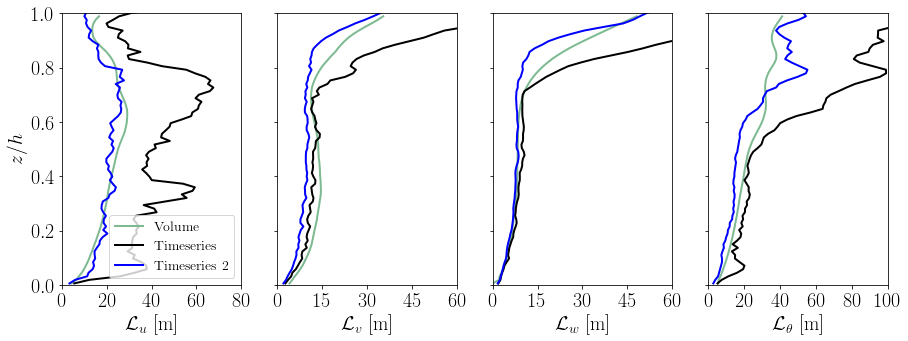

In [10]:
# plot lengthscales from timeseries for comparison
# load ts file
Lts = xr.load_dataset(dnc_all[0]+"L_ts.nc")
Lts2 = xr.load_dataset(dnc_all[0]+"L_ts_2.nc")
# four panel: u, v, w, theta
fig1b, ax1b = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14.8, 5))
# u
ax1b[0].plot(Lall[0].u_rot, Lall[0].z/sall[0].h, ls="-", 
             lw=2, c=colors[0], label="Volume")
ax1b[0].plot(Lts.u, Lts.z/sall[0].h, ls="-", lw=2, c="k", label="Timeseries")
ax1b[0].plot(Lts2.u, Lts.z/sall[0].h, ls="-", lw=2, c="b", label="Timeseries 2")
# v
ax1b[1].plot(Lall[0].v_rot, Lall[0].z/sall[0].h, ls="-", lw=2, c=colors[0])
ax1b[1].plot(Lts.v, Lts.z/sall[0].h, ls="-", lw=2, c="k")
ax1b[1].plot(Lts2.v, Lts.z/sall[0].h, ls="-", lw=2, c="b")
# w
ax1b[2].plot(Lall[0].w, Lall[0].z/sall[0].h, ls="-", lw=2, c=colors[0])
ax1b[2].plot(Lts.w, Lts.z/sall[0].h, ls="-", lw=2, c="k")
ax1b[2].plot(Lts2.w, Lts.z/sall[0].h, ls="-", lw=2, c="b")
# theta
ax1b[3].plot(Lall[0].theta, Lall[0].z/sall[0].h, ls="-", lw=2, c=colors[0])
ax1b[3].plot(Lts.theta, Lts.z/sall[0].h, ls="-", lw=2, c="k")
ax1b[3].plot(Lts2.theta, Lts.z/sall[0].h, ls="-", lw=2, c="b")
# labels
ax1b[0].legend(fontsize=14)
ax1b[0].set_ylim([0, 1])
ax1b[0].set_ylabel("$z/h$")
ax1b[0].set_xlim([0, 80])
ax1b[0].xaxis.set_major_locator(MultipleLocator(20))
ax1b[0].set_xlabel("$\\mathcal{L}_u$ [m]")

ax1b[1].set_xlim([0, 60])
ax1b[1].xaxis.set_major_locator(MultipleLocator(15))
ax1b[1].set_xlabel("$\\mathcal{L}_v$ [m]")

ax1b[2].set_xlim([0, 60])
ax1b[2].xaxis.set_major_locator(MultipleLocator(15))
ax1b[2].set_xlabel("$\\mathcal{L}_w$ [m]")

ax1b[3].set_xlim([0, 100])
ax1b[3].xaxis.set_major_locator(MultipleLocator(20))
ax1b[3].set_xlabel("$\\mathcal{L}_{\\theta}$ [m]")

Text(0.5, 0, '$\\mathcal{L}_{\\theta}$ [m]')

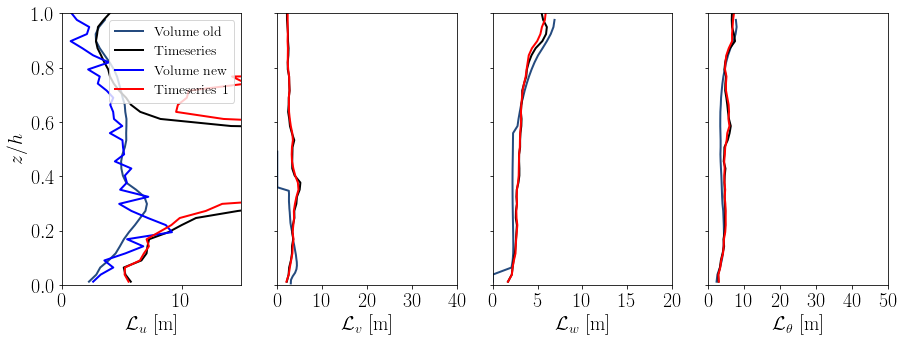

In [12]:
# plot lengthscales from timeseries for comparison
# load ts file
Lts = xr.load_dataset(dnc_all[-1]+"L_ts.nc")
Lts2 = xr.load_dataset(dnc_all[-1]+"L_ts_2.nc")
Lts1 = xr.load_dataset(dnc_all[-1]+"L_ts_1.nc")
Lvol = xr.load_dataset(dnc_all[-1]+"L_vol.nc")
# four panel: u, v, w, theta
fig1b, ax1b = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14.8, 5))
# u
ax1b[0].plot(Lall[-1].u_rot, Lall[-1].z/sall[-1].h, ls="-", 
             lw=2, c=colors[-1], label="Volume old")
ax1b[0].plot(Lts.u, Lts.z/sall[-1].h, ls="-", lw=2, c="k", label="Timeseries")
ax1b[0].plot(Lvol.u, Lvol.z/sall[-1].h, ls="-", lw=2, c="b", label="Volume new")
ax1b[0].plot(Lts1.u, Lts.z/sall[-1].h, ls="-", lw=2, c="r", label="Timeseries 1")
# v
ax1b[1].plot(Lall[-1].v_rot, Lall[-1].z/sall[0].h, ls="-", lw=2, c=colors[-1])
ax1b[1].plot(Lts.v, Lts.z/sall[-1].h, ls="-", lw=2, c="k")
# ax1b[1].plot(Lvol.v, Lts.z/sall[-1].h, ls="-", lw=2, c="b")
ax1b[1].plot(Lts1.v, Lts.z/sall[-1].h, ls="-", lw=2, c="r")
# w
ax1b[2].plot(Lall[-1].w, Lall[-1].z/sall[-1].h, ls="-", lw=2, c=colors[-1])
ax1b[2].plot(Lts.w, Lts.z/sall[-1].h, ls="-", lw=2, c="k")
# ax1b[2].plot(Lvol.w, Lts.z/sall[-1].h, ls="-", lw=2, c="b")
ax1b[2].plot(Lts1.w, Lts.z/sall[-1].h, ls="-", lw=2, c="r")
# theta
ax1b[3].plot(Lall[-1].theta, Lall[-1].z/sall[-1].h, ls="-", lw=2, c=colors[-1])
ax1b[3].plot(Lts.theta, Lts.z/sall[-1].h, ls="-", lw=2, c="k")
# ax1b[3].plot(Lvol.theta, Lts.z/sall[-1].h, ls="-", lw=2, c="b")
ax1b[3].plot(Lts1.theta, Lts.z/sall[-1].h, ls="-", lw=2, c="r")
# labels
ax1b[0].legend(fontsize=14)
ax1b[0].set_ylim([0, 1])
ax1b[0].set_ylabel("$z/h$")
ax1b[0].set_xlim([0, 15])
# ax1b[0].xaxis.set_major_locator(MultipleLocator(25))
ax1b[0].set_xlabel("$\\mathcal{L}_u$ [m]")

ax1b[1].set_xlim([0, 40])
ax1b[1].xaxis.set_major_locator(MultipleLocator(10))
ax1b[1].set_xlabel("$\\mathcal{L}_v$ [m]")

ax1b[2].set_xlim([0, 20])
ax1b[2].xaxis.set_major_locator(MultipleLocator(5))
ax1b[2].set_xlabel("$\\mathcal{L}_w$ [m]")

ax1b[3].set_xlim([0, 50])
ax1b[3].xaxis.set_major_locator(MultipleLocator(10))
ax1b[3].set_xlabel("$\\mathcal{L}_{\\theta}$ [m]")

In [11]:
Lvol.u

<xarray.DataArray 'u' (z: 47)>
array([2.61790488, 3.24901255, 4.29967202, 3.55472316, 5.30817327,
       6.80658875, 5.45271076, 9.20196629, 8.69021679, 7.19064992,
       5.81171825, 4.79438255, 7.22683801, 4.87320477, 5.43404733,
       5.26861969, 5.80838615, 4.43306941, 5.20543434, 5.11270996,
       5.06652796, 4.0163905 , 5.05024988, 4.35700908, 4.29043358,
       4.04475398, 4.29974643, 3.75119646, 3.00559656, 3.16990091,
       2.19767202, 3.93070608, 2.61129346, 1.71315355, 0.73773033,
       2.09685259, 2.28889831, 1.25696732, 0.78434791, 1.47882649,
       0.69939744, 0.09218969, 1.28844652, 1.01036661, 0.16392587,
       0.06120133, 0.13121863])
Coordinates:
  * z        (z) float64 1.042 3.136 5.23 7.324 ... 91.09 93.19 95.28 97.38

5.376832900651987


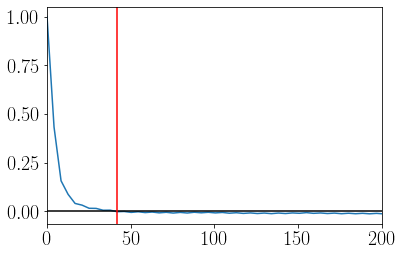

In [7]:
# plot autocorrelations
R = Aall[-1]
Ru = R.u_rot.sel(z=45, method="nearest")

fig1a, ax1a = plt.subplots(1)
ax1a.plot(R.x, Ru)
ax1a.set_xlim([0, 200])
ax1a.axhline(0, c="k")

izero = np.where(Ru < 0.)[0][0]
print(Ru.isel(x=range(izero)).integrate("x").values)
ax1a.axvline(Ru.x[izero], color="r")

Text(0.5, 0, '$\\mathcal{L}_{\\sigma_{\\theta}^2}$ [m]')

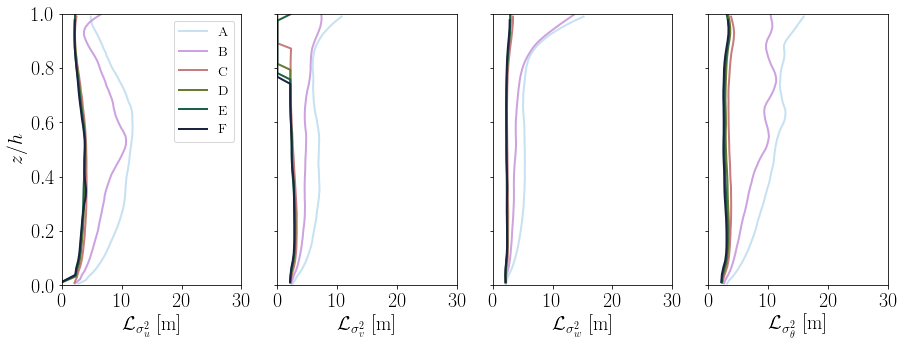

In [8]:
# four panel: u, v, w, theta variances
fig2, ax2 = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14.8, 5))
for i, (l, s) in enumerate(zip(Lall, sall)):
    # u
    ax2[0].plot(l.uu_var_rot, l.z/s.h, ls="-", lw=2, c=cmap[i], label=s.label2)
    # v
    ax2[1].plot(l.vv_var_rot, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # w
    ax2[2].plot(l.ww_var, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # theta
    ax2[3].plot(l.tt_var, l.z/s.h, ls="-", lw=2, c=cmap[i])
# labels
ax2[0].legend(fontsize=14)
ax2[0].set_ylim([0, 1])
ax2[0].set_ylabel("$z/h$")
ax2[0].set_xlim([0, 30])
ax2[0].xaxis.set_major_locator(MultipleLocator(10))
ax2[0].set_xlabel("$\\mathcal{L}_{\\sigma_u^2}$ [m]")

ax2[1].set_xlim([0, 30])
ax2[1].xaxis.set_major_locator(MultipleLocator(10))
ax2[1].set_xlabel("$\\mathcal{L}_{\\sigma_v^2}$ [m]")

ax2[2].set_xlim([0, 30])
ax2[2].xaxis.set_major_locator(MultipleLocator(10))
ax2[2].set_xlabel("$\\mathcal{L}_{\\sigma_w^2}$ [m]")

ax2[3].set_xlim([0, 30])
ax2[3].xaxis.set_major_locator(MultipleLocator(10))
ax2[3].set_xlabel("$\\mathcal{L}_{\\sigma_{\\theta}^2}$ [m]")

In [9]:
# four panel: u, v, w, theta variances
# load ts file
Lts = xr.load_dataset(dnc_all[0]+"L_ts_4.nc")
fig2a, ax2a = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14.8, 5))
# u
ax2a[0].plot(Lall[0].uu_var_rot, Lall[0].z/sall[0].h, ls="-", lw=2, c=cmap[0], label="Volume")
ax2a[0].plot(Lts.uuvar2, Lts.z/sall[0].h, ls="-", lw=2, c="k", label="Timeseries")
# v
ax2a[1].plot(Lall[0].vv_var_rot, Lall[0].z/sall[0].h, ls="-", lw=2, c=cmap[0])
ax2a[1].plot(Lts.vvvar2, Lts.z/sall[0].h, ls="-", lw=2, c="k")
# w
ax2a[2].plot(Lall[0].ww_var, Lall[0].z/sall[0].h, ls="-", lw=2, c=cmap[0])
ax2a[2].plot(Lts.wwvar2, Lts.z/sall[0].h, ls="-", lw=2, c="k")
# theta
ax2a[3].plot(Lall[0].tt_var, Lall[0].z/sall[0].h, ls="-", lw=2, c=cmap[0])
ax2a[3].plot(Lts.ttvar2, Lts.z/sall[0].h, ls="-", lw=2, c="k")
# labels
ax2a[0].legend(fontsize=14)
ax2a[0].set_ylim([0, 1])
ax2a[0].set_ylabel("$z/h$")
ax2a[0].set_xlim([0, 30])
ax2a[0].xaxis.set_major_locator(MultipleLocator(10))
ax2a[0].set_xlabel("$\\mathcal{L}_{\\sigma_u^2}$ [m]")

ax2a[1].set_xlim([0, 30])
ax2a[1].xaxis.set_major_locator(MultipleLocator(10))
ax2a[1].set_xlabel("$\\mathcal{L}_{\\sigma_v^2}$ [m]")

ax2a[2].set_xlim([0, 30])
ax2a[2].xaxis.set_major_locator(MultipleLocator(10))
ax2a[2].set_xlabel("$\\mathcal{L}_{\\sigma_w^2}$ [m]")

ax2a[3].set_xlim([0, 30])
ax2a[3].xaxis.set_major_locator(MultipleLocator(10))
ax2a[3].set_xlabel("$\\mathcal{L}_{\\sigma_{\\theta}^2}$ [m]")

FileNotFoundError: [Errno 2] No such file or directory: b'/home/bgreene/simulations/cr0.25_u08_192/output/netcdf/L_ts_4.nc'

Text(0.5, 0, "$\\mathcal{L}_{\\overline{\\theta'w'}}$ [m]")

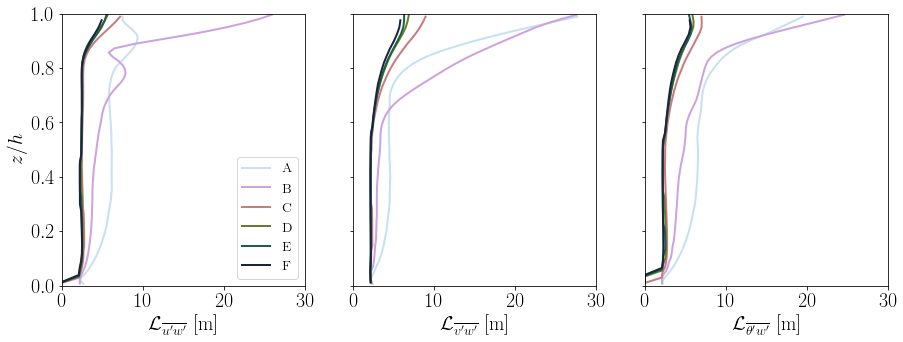

In [ ]:
# three panel: uw, vw, tw covariances
fig3, ax3 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
for i, (l, s) in enumerate(zip(Lall, sall)):
    # uw
    ax3[0].plot(l.uw_cov_tot, l.z/s.h, ls="-", lw=2, c=cmap[i], label=s.label2)
    # vw
    ax3[1].plot(l.vw_cov_tot, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # tw
    ax3[2].plot(l.tw_cov_tot, l.z/s.h, ls="-", lw=2, c=cmap[i])
# labels
ax3[0].legend(fontsize=14)
ax3[0].set_ylim([0, 1])
ax3[0].set_ylabel("$z/h$")
ax3[0].set_xlim([0, 30])
ax3[0].xaxis.set_major_locator(MultipleLocator(10))
ax3[0].set_xlabel("$\\mathcal{L}_{\\overline{u'w'}}$ [m]")

ax3[1].set_xlim([0, 30])
ax3[1].xaxis.set_major_locator(MultipleLocator(10))
ax3[1].set_xlabel("$\\mathcal{L}_{\\overline{v'w'}}$ [m]")

ax3[2].set_xlim([0, 30])
ax3[2].xaxis.set_major_locator(MultipleLocator(10))
ax3[2].set_xlabel("$\\mathcal{L}_{\\overline{\\theta'w'}}$ [m]")

Text(0.5, 0, "$\\mathcal{L}_{\\overline{\\theta'w'}}$ [m]")

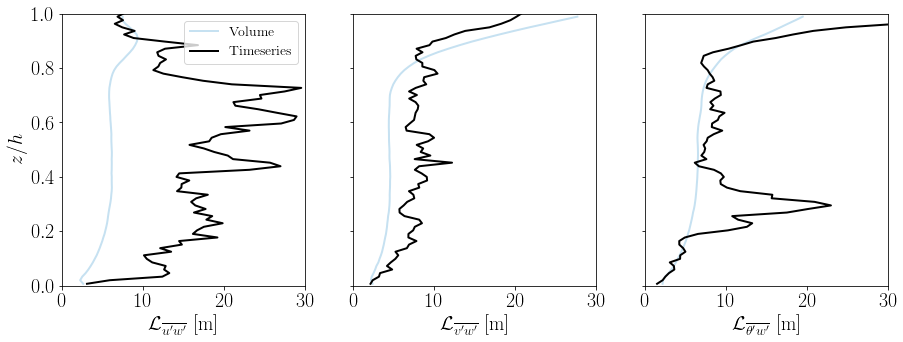

In [ ]:
# three panel: uw, vw, tw, covariances
# load ts file
Lts = xr.load_dataset(dnc_all[0]+"L_ts.nc")
fig3a, ax3a = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
# uw
ax3a[0].plot(Lall[0].uw_cov_tot, Lall[0].z/sall[0].h, ls="-", lw=2, c=cmap[0], label="Volume")
ax3a[0].plot(Lts.uuvar2, Lts.z/sall[0].h, ls="-", lw=2, c="k", label="Timeseries")
# vw
ax3a[1].plot(Lall[0].vw_cov_tot, Lall[0].z/sall[0].h, ls="-", lw=2, c=cmap[0])
ax3a[1].plot(Lts.vvvar2, Lts.z/sall[0].h, ls="-", lw=2, c="k")
# tw
ax3a[2].plot(Lall[0].tw_cov_tot, Lall[0].z/sall[0].h, ls="-", lw=2, c=cmap[0])
ax3a[2].plot(Lts.wwvar2, Lts.z/sall[0].h, ls="-", lw=2, c="k")
# labels
ax3a[0].legend(fontsize=14)
ax3a[0].set_ylim([0, 1])
ax3a[0].set_ylabel("$z/h$")
ax3a[0].set_xlim([0, 30])
ax3a[0].xaxis.set_major_locator(MultipleLocator(10))
ax3a[0].set_xlabel("$\\mathcal{L}_{\\overline{u'w'}}$ [m]")

ax3a[1].set_xlim([0, 30])
ax3a[1].xaxis.set_major_locator(MultipleLocator(10))
ax3a[1].set_xlabel("$\\mathcal{L}_{\\overline{v'w'}}$ [m]")

ax3a[2].set_xlim([0, 30])
ax3a[2].xaxis.set_major_locator(MultipleLocator(10))
ax3a[2].set_xlabel("$\\mathcal{L}_{\\overline{\\theta'w'}}$ [m]")

# Plot Error Profiles

Saving figure: /home/bgreene/SBL_LES/figures/RFMnc/errors/uh_alpha_theta.pdf


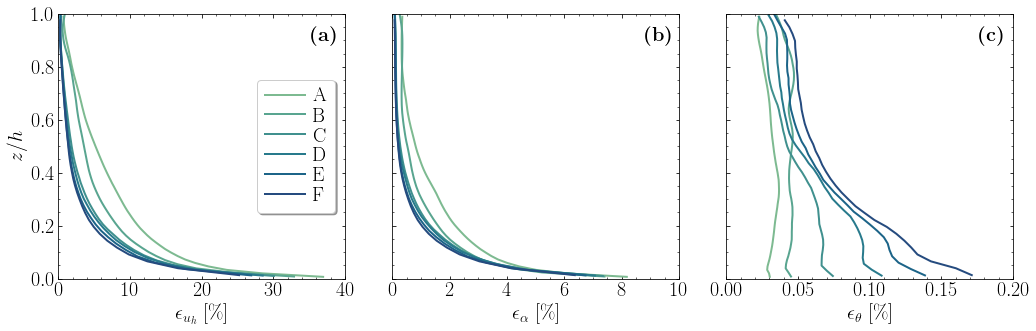

In [7]:
# Figure 1: 3-panel 1st order moments
# wind speed, wind direction, potential temperature
fig1, ax1 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
# loop through simulations
for i, (e, s) in enumerate(zip(err, sall)):
    # uh
    ax1[0].plot(100.*e.uh, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # alpha
    ax1[1].plot(100.*e.alpha, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta
    ax1[2].plot(100.*e.theta, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
# labels
ax1[0].set_xlabel("$\\epsilon_{u_h}$ [\%]")
ax1[0].set_ylabel("$z/h$")
ax1[0].set_xlim([0, 40])
ax1[0].xaxis.set_major_locator(MultipleLocator(10))
ax1[0].xaxis.set_minor_locator(MultipleLocator(2))
ax1[0].set_ylim([0, 1])
ax1[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax1[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax1[0].legend(loc="right", labelspacing=0.10, handletextpad=0.4, shadow=True)
ax1[1].set_xlabel("$\\epsilon_{\\alpha}$ [\%]")
ax1[1].set_xlim([0, 10])
ax1[1].xaxis.set_major_locator(MultipleLocator(2))
ax1[1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax1[2].set_xlabel("$\\epsilon_{\\theta}$ [\%]")
ax1[2].set_xlim([0, 0.2])
ax1[2].xaxis.set_major_locator(MultipleLocator(0.05))
ax1[2].xaxis.set_minor_locator(MultipleLocator(0.01))
# edit ticks and add subplot labels
for iax, s in zip(ax1, list("abc")):
    iax.tick_params(which="both", direction="in", top=True, right=True)
    iax.text(0.88,0.90,f"$\\textbf{{({s})}}$",fontsize=20,
                transform=iax.transAxes)
fig1.tight_layout()
# save and close
fsave1 = f"{figdir}errors/uh_alpha_theta.pdf"
print(f"Saving figure: {fsave1}")
fig1.savefig(fsave1)
# plt.close(fig1)

Saving figure: /home/bgreene/SBL_LES/figures/RFMnc/errors/second_order_all.pdf


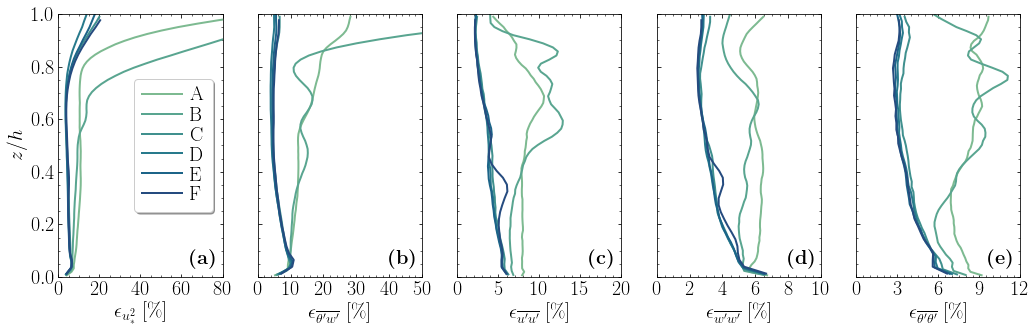

In [12]:
# Figure 2: 5-panel covariances and variances
# ustar2, theta'w', u'u', w'w', theta'theta'
fig2, ax2 = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(14.8, 5))
# loop through simulations
for i, (e, s) in enumerate(zip(err, sall)):
    # u'w'
    ax2[0].plot(100.*e.ustar2, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta'w'
    ax2[1].plot(100.*e.tw_cov_tot, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # u'u' rotated
    ax2[2].plot(100.*e.uu_var_rot, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # w'w'
    ax2[3].plot(100.*e.ww_var, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # t't'
    ax2[4].plot(100.*e.tt_var, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
# labels
ax2[0].set_ylabel("$z/h$")
ax2[0].set_ylim([0, 1])
ax2[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax2[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax2[0].set_xlabel("$\\epsilon_{u_{*}^2}$ [\%]")
ax2[0].set_xlim([0, 80])
ax2[0].xaxis.set_major_locator(MultipleLocator(20))
ax2[0].xaxis.set_minor_locator(MultipleLocator(5))
ax2[0].legend(loc="right", labelspacing=0.10, handletextpad=0.4, shadow=True)
ax2[1].set_xlabel("$\\epsilon_{\\overline{\\theta'w'}}$ [\%]")
ax2[1].set_xlim([0, 50])
ax2[1].xaxis.set_major_locator(MultipleLocator(10))
ax2[1].xaxis.set_minor_locator(MultipleLocator(2))
ax2[2].set_xlabel("$\\epsilon_{\\overline{u'u'}}$ [\%]")
ax2[2].set_xlim([0, 20])
ax2[2].xaxis.set_major_locator(MultipleLocator(5))
ax2[2].xaxis.set_minor_locator(MultipleLocator(1))
ax2[3].set_xlabel("$\\epsilon_{\\overline{w'w'}}$ [\%]")
ax2[3].set_xlim([0, 10])
ax2[3].xaxis.set_major_locator(MultipleLocator(2))
ax2[3].xaxis.set_minor_locator(MultipleLocator(0.5))
ax2[4].set_xlim([0, 12])
ax2[4].xaxis.set_major_locator(MultipleLocator(3))
ax2[4].xaxis.set_minor_locator(MultipleLocator(0.5))
ax2[4].set_xlabel("$\\epsilon_{\\overline{\\theta'\\theta'}}$ [\%]")
# edit ticks and add subplot labels
for iax, s in zip(ax2, list("abcde")):
    iax.tick_params(which="both", direction="in", top=True, right=True)
    iax.text(0.8,0.05,f"$\\textbf{{({s})}}$",fontsize=20,
                transform=iax.transAxes)
fig2.tight_layout()
# save and close
fsave2 = f"{figdir}errors/second_order_all.pdf"
print(f"Saving figure: {fsave2}")
fig2.savefig(fsave2)
# plt.close(fig2)

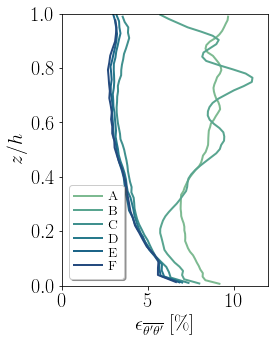

In [ ]:
fig2a, ax2a = plt.subplots(1, figsize=(3.7, 5))
for i, (e, s) in enumerate(zip(err, sall)):
    ax2a.plot(100*e.tt_var, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
# labels
ax2a.set_ylim([0, 1])
ax2a.set_ylabel("$z/h$")
ax2a.set_xlim([0, 12])
ax2a.set_xlabel("$\\epsilon_{\\overline{\\theta'\\theta'}}$ [\%]")
ax2a.legend(fontsize=14, labelspacing=0.10, handletextpad=0.4, shadow=True)

# Plot 2d Error

In [13]:
# construct Tnew from config file
Tnew0 = config["recalc_lo"]
Tnew1 = config["recalc_hi"]
Tnewdt = config["recalc_dt"]
Tnew = np.arange(Tnew0, Tnew1, Tnewdt, dtype=np.float64)
#
# plot one six-panel figure for A & F, uh, alpha, theta
#
# first recalc errors
Aerr = recalc_err("cr0.25_u08_192", Tnew)
Ferr = recalc_err("cr2.50_u08_192", Tnew)

Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.50_u08_192/output/netcdf/average_statistics.nc


Saving figure: /home/bgreene/SBL_LES/figures/RFMnc/errors2d/AF_uh_alpha_theta.pdf


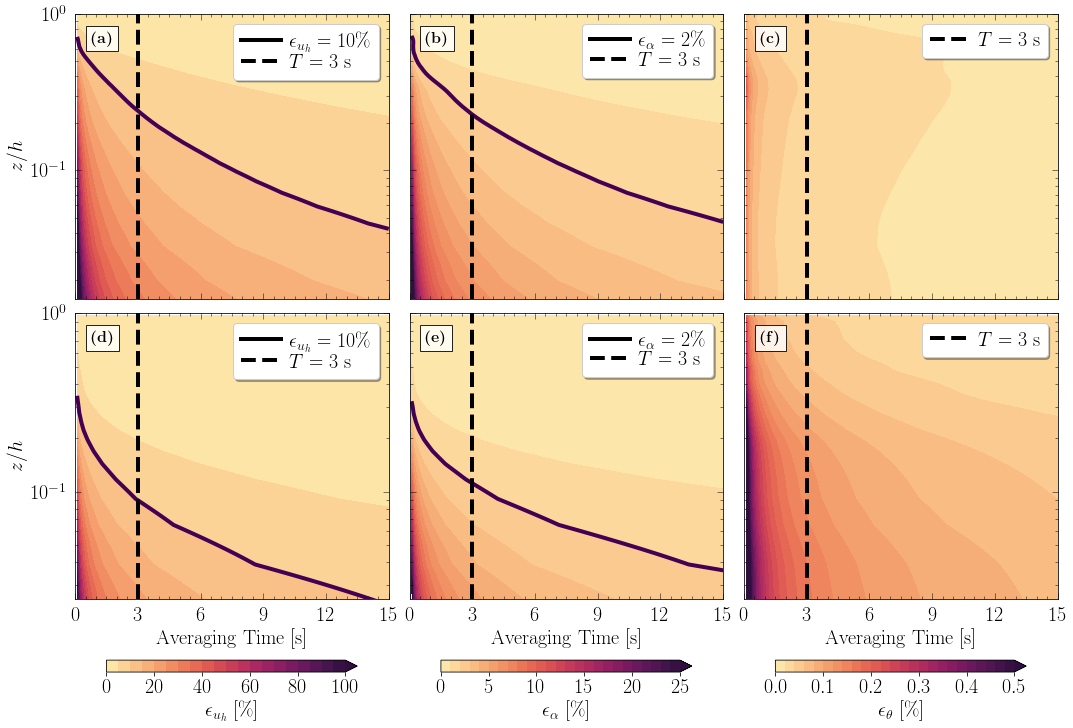

In [14]:
# plot
# figure 1: rows=A, F; columns=uh, alpha, theta
fig3, ax3 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row", 
                         constrained_layout=True, figsize=(14.8, 10))
# uh
# A
cfax00 = ax3[0,0].contourf(Aerr.Tsample, Aerr.z/Aerr.h, 100*Aerr.uh,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 100, 21))
# plot blue line outside of window to use in legend
ax3[0,0].axhline(-10, ls="-", lw=4, c="k", label="$\\epsilon_{u_h}=10\%$")
# F
cfax10 = ax3[1,0].contourf(Ferr.Tsample, Ferr.z/Ferr.h, 100*Ferr.uh,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 100, 21))
# plot blue line outside of window to use in legend
ax3[1,0].axhline(-10, ls="-", lw=4, c="k", label="$\\epsilon_{u_h}=10\%$")
# contour 10% level
cax00 = ax3[0,0].contour(Aerr.Tsample, Aerr.z/Aerr.h, 100.*Aerr.uh,
                        "-k", levels=[10.], linewidths=4.)
cax10 = ax3[1,0].contour(Ferr.Tsample, Ferr.z/Ferr.h, 100.*Ferr.uh,
                        "-k", levels=[10.], linewidths=4.)
# # alpha
# A
cfax01 = ax3[0,1].contourf(Aerr.Tsample, Aerr.z/Aerr.h, 100*Aerr.alpha,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 25, 26))
# plot blue line outside of window to use in legend
ax3[0,1].axhline(-10, ls="-", lw=4, c="k", label="$\\epsilon_{\\alpha}=2\%$")
# F
cfax11 = ax3[1,1].contourf(Ferr.Tsample, Ferr.z/Ferr.h, 100*Ferr.alpha,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 25, 26))
# plot blue line outside of window to use in legend
ax3[1,1].axhline(-10, ls="-", lw=4, c="k", label="$\\epsilon_{\\alpha}=2\%$")
# contour 2% level
cax01 = ax3[0,1].contour(Aerr.Tsample, Aerr.z/Aerr.h, 100.*Aerr.alpha,
                        "-k", levels=[2.], linewidths=4.)
cax11 = ax3[1,1].contour(Ferr.Tsample, Ferr.z/Ferr.h, 100.*Ferr.alpha,
                        "-k", levels=[2.], linewidths=4.)
# theta
# A
cfax02 = ax3[0,2].contourf(Aerr.Tsample, Aerr.z/Aerr.h, 100*Aerr.theta,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 0.5, 26))
# F
cfax12 = ax3[1,2].contourf(Ferr.Tsample, Ferr.z/Ferr.h, 100*Ferr.theta,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 0.5, 26))
# plot vertical dashed lines on each panel
for iax, p in zip(ax3.flatten(), list("abcdef")):
    # plot vertical dashed line at T = 3 s
    iax.axvline(3., ls="--", lw=4, c="k", label="$T = 3$ s")
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
    iax.tick_params(which="major", length=6, width=0.5)
    iax.tick_params(which="minor", length=3, width=0.5)
    iax.text(0.05,0.90,f"$\\textbf{{({p})}}$",fontsize=16,bbox=props2,
                transform=iax.transAxes)
    iax.legend(loc="upper right", labelspacing=0.10, 
                handletextpad=0.4, shadow=True)
# labels
# ax00
ax3[0,0].set_ylabel("$z/h$")
ax3[0,0].set_ylim([0.015, 1])
ax3[0,0].set_yscale("log")
ax3[0,0].set_xlim([0, Tnew1-Tnewdt])
ax3[0,0].xaxis.set_major_locator(MultipleLocator(3))
ax3[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
# ax01 - none
# ax02 - none
# ax10
ax3[1,0].set_ylabel("$z/h$")
ax3[1,0].set_ylim([0.025, 1])
ax3[1,0].set_yscale("log")
ax3[1,0].set_xlabel("Averaging Time [s]")
# ax11
ax3[1,1].set_xlabel("Averaging Time [s]")
# ax12
ax3[1,2].set_xlabel("Averaging Time [s]")
# colorbars
# col 1: uh
cb1 = fig3.colorbar(cfax00, ax=ax3[:,0], location="bottom", shrink=0.8, 
                    ticks=MultipleLocator(20), pad=0.02)
cb1.ax.set_xlabel("$\\epsilon_{u_h}$ [$\%$]")
# col 2: alpha
cb2 = fig3.colorbar(cfax01, ax=ax3[:,1], location="bottom", shrink=0.8, 
                    ticks=MultipleLocator(5), pad=0.02)
cb2.ax.set_xlabel("$\\epsilon_{\\alpha}$ [$\%$]")
# col 3: theta
cb3 = fig3.colorbar(cfax02, ax=ax3[:,2], location="bottom", shrink=0.8, 
                    ticks=MultipleLocator(0.1), pad=0.02)
cb3.ax.set_xlabel("$\\epsilon_{\\theta}$ [$\%$]")
# save and close
fsave = f"{figdir}errors2d/AF_uh_alpha_theta.pdf"
print(f"Saving figure: {fsave}")
fig3.savefig(fsave, format="pdf")
# plt.close(fig)

# Plot RFM Example Fit

In [ ]:
# load RFM.nc file
RFM = xr.load_dataset(dnc_all[0]+"RFM.nc")
# load fit coefficient files
C = xr.load_dataset(dnc_all[0]+"fit_C.nc")
p = xr.load_dataset(dnc_all[0]+"fit_p.nc")
# grab stats data
s = sall[0]

In [ ]:
# select height for plotting
jz = 10
# fit line based on C and p
fit = C.u.isel(z=jz) * (RFM.delta_x ** (-p.u.isel(z=jz)))
# extrapolated value for UAS sampling length
Luas = 3. * s.u_mean.isel(z=jz)
# determine where this intersects with fit to plot dot
Luas2 = C.u.isel(z=jz) * (Luas ** (-p.u.isel(z=jz)))

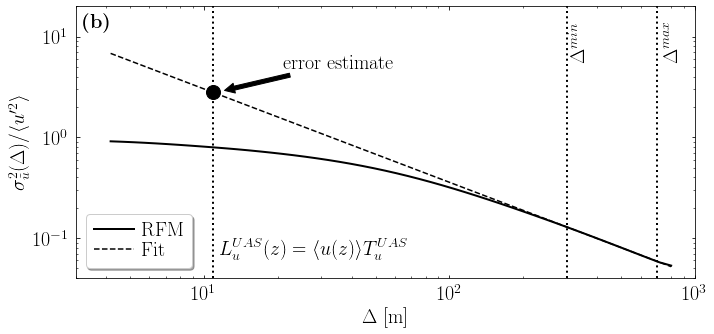

In [ ]:
# plot
fig4, ax4 = plt.subplots(1, figsize=(11.1, 5))
# MSE/var vs deltax from RFM
ax4.plot(RFM.delta_x, RFM.u.isel(z=jz)/s.u_var.isel(z=jz), 
         c="k", ls="-", lw=2, label="RFM")
# fit line
ax4.plot(RFM.delta_x, fit, "--k", label="Fit")
# vertical lines for deltax_min, deltax_max fit windows
ax4.axvline(300, c="k", ls=":", lw=2)
ax4.axvline(700, c="k", ls=":", lw=2)
# vertical line for extrapolated estimate with Tsample=3s
ax4.axvline(Luas, c="k", ls=":", lw=2)
# dot where these intersect
ax4.plot(Luas, Luas2, "ok", markersize=14)
# figure labels
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_xlim([3, 1e3])
ax4.set_xlabel("$\\Delta$ [m]")
ax4.set_ylim([0.04, 20])
ax4.set_ylabel("$\\sigma_{\\tilde{u}}^2 (\\Delta) / \\langle u'^2 \\rangle$")
ax4.legend(fontsize=20, labelspacing=0.10, handletextpad=0.4, shadow=True)
# edit ticks
ax4.tick_params(which="both", direction="in", top=True, right=True, pad=7)
# text labels
ax4.text(310,6,"$\\Delta^{min}$",fontsize=20,bbox=props,rotation="vertical")
ax4.text(740,6,"$\\Delta^{max}$",fontsize=20,bbox=props,rotation="vertical")
ax4.text(11.5,0.07,"$L_u^{UAS}(z)=\\langle u(z) \\rangle T_u^{UAS}$",fontsize=20,bbox=props)
# arrow pointing at Luas2
# ax4.arrow(Luas+10, Luas2, -8, 0, length_includes_head=True, shape="full")
ax4.annotate("error estimate", xy=(Luas+1, Luas2+0.1), xytext=(Luas+10, Luas2+2),
             arrowprops=dict(arrowstyle="simple", fc="k"))
# (b) label
ax4.text(3.7, 14, "$\\textbf{(b)}$", ha="center", va="center", fontsize=20)
# save figure
fsave = f"{figdir}RFM_example_b.pdf"
fig4.savefig(fsave, bbox_inches="tight")

# Filter $u$ and plot versus $x$

In [ ]:
from LESnc import load_full
import xrft
dd, _ = load_full(dnc_all[0], 1259000, 1260000, 1000, 0.02, True, True)
u = dd.u.isel(time=-1,y=95,z=jz)

Loading files...
Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc


In [ ]:
# forward FFT
f_fft = xrft.fft(u, dim="x", true_phase=True, true_amplitude=True)
# define filter sizes
nfilt = 4
delta_x = np.logspace(np.log10(2*dd.dx), np.log10(dd.Lx/2),
                      num=nfilt, base=10.0, dtype=np.float64)
# construct box filter transfer function
dk = 2*np.pi/dd.Lx
filt = np.zeros((nfilt, dd.nx), dtype=np.float64)
# loop over filter sizes
for i, idx in enumerate(delta_x):
    filt[i,0] = 1.
    filt[i,-1] = 1.
    # loop over frequencies
    for j in range(1, dd.nx//2):
        filt[i,j] = np.sin(j*dk*idx/2.) / (j*dk*idx/2.)
        filt[i,dd.nx-j-1] = np.sin(j*dk*idx/2.) / (j*dk*idx/2.)
# fftshift
filt = np.fft.fftshift(filt, axes=1)
# convert filt to xarray DataArray
filt = xr.DataArray(data=filt,
                    coords=dict(delta_x=delta_x,
                                freq_x=f_fft.freq_x)
                   )
# apply filter in x-wavenumber space: loop over filter widths delta_x
# create new DataArray
f_fft_filt = xr.DataArray(data=np.zeros((dd.nx,nfilt), dtype=np.complex128),
                          coords=dict(freq_x=f_fft.freq_x,
                                      delta_x=delta_x)
                         )
for i in range(len(delta_x)):
    f_fft_filt[:,i] = f_fft * filt.isel(delta_x=i)
# after looping over filter widths, calculate inverse fft on x-axis
f_ifft_filt = xrft.ifft(f_fft_filt, dim="freq_x", true_phase=True, 
                        true_amplitude=True,
                        lag=f_fft.freq_x.direct_lag)
u_filt = np.real(f_ifft_filt.compute())

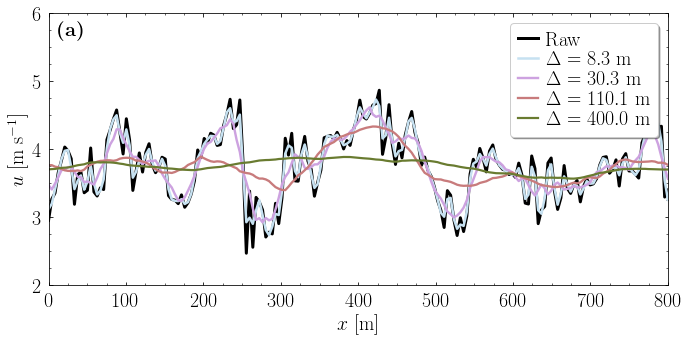

In [ ]:
# plot
fig5, ax5 = plt.subplots(1, figsize=(11.1, 5))
# plot raw u(x)
ax5.plot(dd.x, u, "-k", lw=3, label="Raw")
# plot filtered u(x)
# loop
for i, idx in enumerate(delta_x):
    var = np.var(u_filt[:,i].values)
    lab = f"$\\Delta = {{{idx:3.1f}}}$ m"
    ax5.plot(dd.x, u_filt[:,i], color=cmap[i], 
             lw=2.5-(i*0.1), ls="-", label=lab)
# labels
ax5.legend(loc="upper right", fontsize=20, labelspacing=0.10, handletextpad=0.4, 
           shadow=True, handlelength=1)
ax5.set_xlim([0, 800])
ax5.set_xlabel("$x$ [m]")
ax5.set_ylim([2, 6])
ax5.set_ylabel("$u$ [m s$^{-1}$]")
# edit ticks
ax5.tick_params(which="both", direction="in", top=True, right=True, pad=7)
ax5.xaxis.set_major_locator(MultipleLocator(100))
ax5.xaxis.set_minor_locator(MultipleLocator(25))
ax5.yaxis.set_major_locator(MultipleLocator(1))
ax5.yaxis.set_minor_locator(MultipleLocator(0.25))
# (a) label
ax5.text(30, 5.75, "$\\textbf{(a)}$", ha="center", va="center", fontsize=20)
# save figure
fsave = f"{figdir}RFM_example_a.pdf"
fig5.savefig(fsave, bbox_inches="tight")

In [ ]:
s.z.isel(z=jz)/s.h

<xarray.DataArray ()>
array(0.13755702)
Coordinates:
    z        float64 21.98

# Plot profiles of RFM coefficients $C$ and $p$

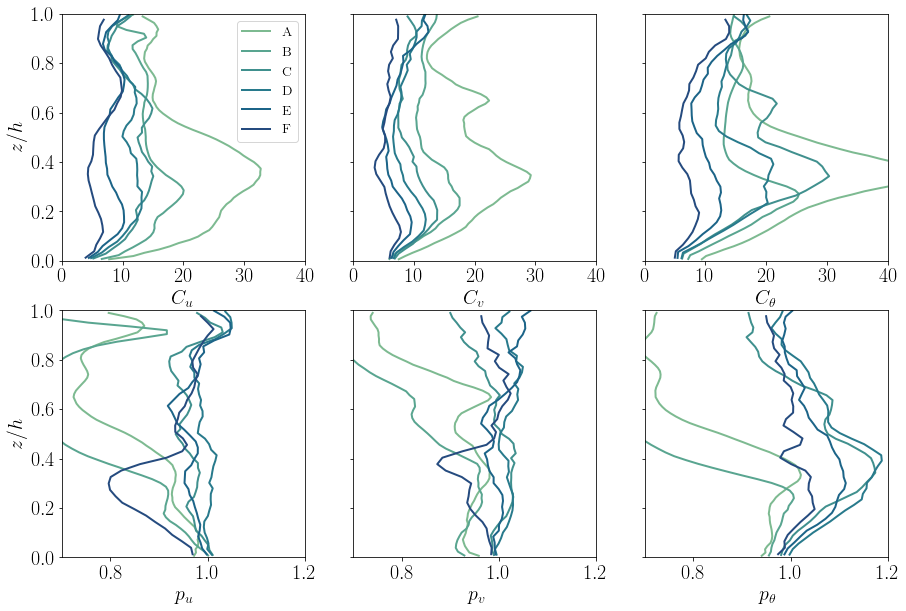

In [23]:
# RFM coefficients: 1st order
# u, v, potential temperature
fig6, ax6 = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(14.8, 10))
# loop through simulations
for i, (C, p, s) in enumerate(zip(Call, pall, sall)):
    # row 1: C
    # u_rot
    ax6[0,0].plot(C.u_rot, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # v_rot
    ax6[0,1].plot(C.v_rot, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta
    ax6[0,2].plot(C.theta, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # row 2: p
    # u_rot
    ax6[1,0].plot(p.u_rot, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # v_rot
    ax6[1,1].plot(p.v_rot, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta
    ax6[1,2].plot(p.theta, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)

# labels
ax6[0,0].set_ylim([0, 1])
ax6[0,0].set_ylabel("$z/h$")
ax6[1,0].set_ylabel("$z/h$")
[iax.set_xlim([0, 40]) for iax in ax6[0,:]]
ax6[0,0].set_xlabel("$C_u$")
ax6[0,1].set_xlabel("$C_v$")
ax6[0,2].set_xlabel("$C_{\\theta}$")

[iax.set_xlim([0.7, 1.2]) for iax in ax6[1,:]]
ax6[1,0].set_xlabel("$p_u$")
ax6[1,1].set_xlabel("$p_v$")
ax6[1,2].set_xlabel("$p_{\\theta}$")

# legend
ax6[0,0].legend(fontsize=14)

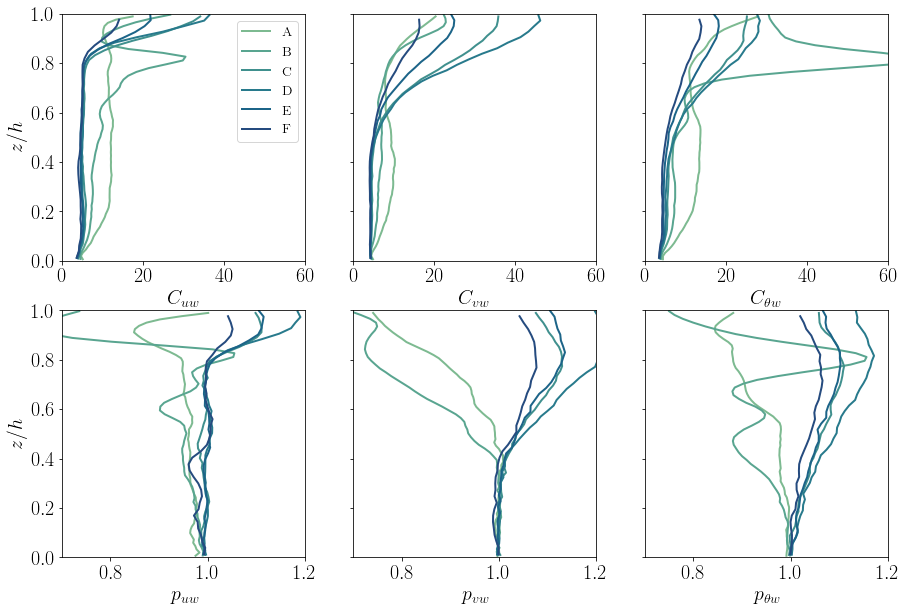

In [25]:
# RFM coefficients: 2nd order (fluxes)
# u, v, potential temperature
fig7, ax7 = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(14.8, 10))
# loop through simulations
for i, (C, p, s) in enumerate(zip(Call, pall, sall)):
    # row 1: C
    # u_rot
    ax7[0,0].plot(C.uw_cov_tot, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # v_rot
    ax7[0,1].plot(C.vw_cov_tot, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta
    ax7[0,2].plot(C.tw_cov_tot, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # row 2: p
    # u_rot
    ax7[1,0].plot(p.uw_cov_tot, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # v_rot
    ax7[1,1].plot(p.vw_cov_tot, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta
    ax7[1,2].plot(p.tw_cov_tot, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)

# labels
ax7[0,0].set_ylim([0, 1])
ax7[0,0].set_ylabel("$z/h$")
ax7[1,0].set_ylabel("$z/h$")
[iax.set_xlim([0, 60]) for iax in ax7[0,:]]
ax7[0,0].set_xlabel("$C_{uw}$")
ax7[0,1].set_xlabel("$C_{vw}$")
ax7[0,2].set_xlabel("$C_{\\theta w}$")

[iax.set_xlim([0.7, 1.2]) for iax in ax7[1,:]]
ax7[1,0].set_xlabel("$p_{uw}$")
ax7[1,1].set_xlabel("$p_{vw}$")
ax7[1,2].set_xlabel("$p_{\\theta w}$")

# legend
ax7[0,0].legend(fontsize=14)

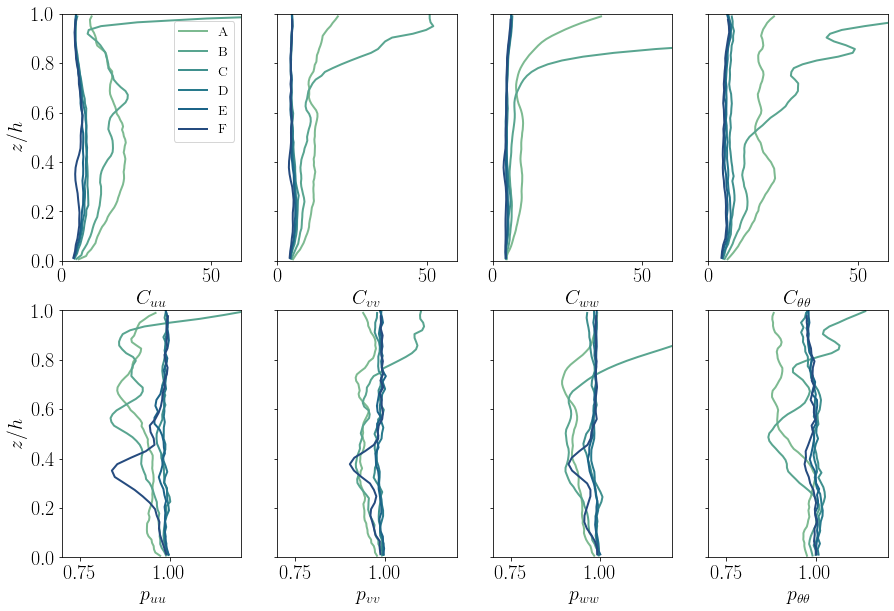

In [47]:
# RFM coefficients: 2nd order (vars)
# u, v, potential temperature
fig8, ax8 = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(14.8, 10))
# loop through simulations
for i, (C, p, s) in enumerate(zip(Call, pall, sall)):
    # row 1: C
    # uu rot
    ax8[0,0].plot(C.uu_var_rot, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # vv rot
    ax8[0,1].plot(C.vv_var_rot, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # ww
    ax8[0,2].plot(C.ww_var, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # tt
    ax8[0,3].plot(C.tt_var, C.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # row 2: p
    # uu
    ax8[1,0].plot(p.uu_var_rot, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # vv
    ax8[1,1].plot(p.vv_var_rot, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # ww
    ax8[1,2].plot(p.ww_var, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta
    ax8[1,3].plot(p.tt_var, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)

# labels
ax8[0,0].set_ylim([0, 1])
ax8[0,0].set_ylabel("$z/h$")
ax8[1,0].set_ylabel("$z/h$")
[iax.set_xlim([0, 60]) for iax in ax8[0,:]]
ax8[0,0].set_xlabel("$C_{uu}$")
ax8[0,1].set_xlabel("$C_{vv}$")
ax8[0,2].set_xlabel("$C_{ww}$")
ax8[0,3].set_xlabel("$C_{\\theta \\theta}$")

[iax.set_xlim([0.7, 1.2]) for iax in ax8[1,:]]
ax8[1,0].set_xlabel("$p_{uu}$")
ax8[1,1].set_xlabel("$p_{vv}$")
ax8[1,2].set_xlabel("$p_{ww}$")
ax8[1,3].set_xlabel("$p_{\\theta \\theta}$")

# legend
ax8[0,0].legend(fontsize=14)

# Plot integral length scales calculated from RFM errors

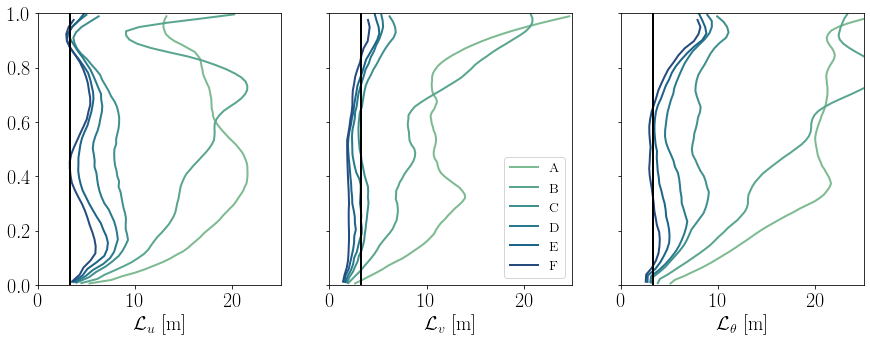

In [76]:
# Figure 1: 3-panel 1st order moments
# u, v, theta
fig9, ax9 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
# loop through simulations
for i, (C, p, s) in enumerate(zip(Call, pall, sall)):
    # calculate L
    Lsample = s.u_mean_rot * 3.0
    Lu = (C.u * Lsample**(-p.u+1)) / 2 #(2 * s.u_var)
    Lv = (C.v * Lsample**(-p.v+1)) / 2 #(2 * s.v_var)
    Lt = (C.theta * Lsample**(-p.theta+1)) / 2 #(2 * s.theta_var)

    # u
    ax9[0].plot(Lu, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # v
    ax9[1].plot(Lv, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta
    ax9[2].plot(Lt, p.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)

# labels
ax9[0].set_ylim([0, 1])
ax9[0].set_xlim([0, 25])
ax9[0].set_xlabel("$\\mathcal{L}_u$ [m]")
ax9[1].set_xlim([0, 25])
ax9[1].set_xlabel("$\\mathcal{L}_v$ [m]")
ax9[2].set_xlim([0, 25])
ax9[2].set_xlabel("$\\mathcal{L}_{\\theta}$ [m]")
ax9[1].legend(fontsize=14)
[iax.axvline(s.delta, c="k", lw=2) for iax in ax9]